# IMAGE COLORIZATION USING cGAN

**Contents**

1. [Import Packages](#packages)
2. [Utils](#utils)
3. [Data preparation](#dataset)
4. [Image Colorization and Color Science Computation](#4-image-colorization-and-color-science-computations)
5. [Generator architecture](#generator)
6. [Discriminator architecture](#discriminator)
7. [Trainer](#training)
8. [Validation](#validation)

## 1. Import Packages <a class="anchor" id="packages"></a>

In [1]:
# Operating system and file operations
import os

# Numerical operations and array processing
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Random number generation
import random

# Image processing and computer vision
import cv2

# Deep learning and neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

# Data handling for deep learning
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Displaying model information
from torchsummary import summary

# Image manipulation
from PIL import Image

# Type annotations
from typing import List

# Progress bar for Jupyter Notebooks
from tqdm.notebook import tqdm

# Color space conversions
from colour import sRGB_to_XYZ, XYZ_to_Lab, Lab_to_XYZ, XYZ_to_sRGB

# Image quality assessment
from skimage.metrics import structural_similarity as ssim

# Memory management
import gc

# Handling warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

c:\Users\Lenovo\.conda\envs\ulos\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Lenovo\.conda\envs\ulos\lib\site-packages\colour\utilities\verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


## 2. Utils <a class="anchor" id="utils"></a>

In [2]:
# Determine the device to use for PyTorch operations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Print the selected device which device will be used for PyTorch operations.
print(device)

cpu


#### Device Configuration for PyTorch

The script determines and prints the computing device to be used for PyTorch operations based on hardware availability:

1. **Determine the Device**: The code checks if a CUDA-enabled GPU is available. If yes, it sets the device to `'cuda'` to enable GPU acceleration. If not, it defaults to `'cpu'`.
2. **Print Device Information**: It then prints the chosen device (`'cuda'` or `'cpu'`) to the console. This confirmation is useful for verifying that the intended hardware (GPU or CPU) is set for executing the operations.


=======================================================================

## 3. Data Preparation

The data preparation process is a crucial step in ensuring the quality and effectiveness of the image colorization model.

#### Dataset Description
- **Total Images**: 64 images.
- **Image Formats**: Each image is available in two versions: grayscale and color.
- **Image Resolution**: The images have been processed to a consistent resolution, suitable for model processing.

#### Data Split
The dataset has been divided into two main subsets for training and testing the model:
- **Training Data**: 80% of the total images (51 images) are used for model training. The training data includes a mix of grayscale and color images, allowing the model to learn to recognize and reproduce colors from grayscale images.
- **Testing Data**: 20% of the total images (13 images) are used as a test set to evaluate the model's performance. Testing ensures that the model can generalize what it has learned to new, unseen images.

=======================================================================

## 4. Image Colorization and Color Science Computations

The script is designed to handle the image colorization process using deep learning frameworks in PyTorch. It details the steps from dataset preparation, transformations, to model inference and visualization:

1. **Color Space Conversion Functions**: Includes a function `lab_to_rgb` that converts images from the LAB color space to RGB using the torch and colour libraries. This function processes a batch of images for display or further processing.

2. **Image Transformations**: Defines transformations to resize and normalize images. These transformations prepare images for consistent processing and improve model training efficiency.

3. **Custom Dataset Class**: `ImageColorizeDataset` is a PyTorch dataset class that handles loading and preprocessing of images. It splits images into input and output parts, applies transformations, and adjusts the data format for model processing.

4. **Data Loaders**: Set up for both training and testing, facilitating the easy batching of data for processing by the model.

5. **Model Training and Inference Setup**: Orchestrates the flow from loading data, applying transformations, making predictions with the model, and preparing the images for visualization.

6. **Visualization**: Displays a grid of original and colorized images using matplotlib, demonstrating the effectiveness of the model in a visual format.

In [3]:
def lab_to_rgb_save(L, ab, device, save_dir="./output"):
    """
    Takes a batch of images
    """
    L = 100 * L  # Scale the L component from 0-1 to 0-100
    ab = (ab - 0.5) * 256  # Adjust the a and b components to the correct range
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()  # Combine L, a, b, and rearrange the format for processing
    rgb_imgs = []  # Initialize a list to store the resulting RGB images

    rgb_imgs = []  # Initialize a list to store the resulting RGB images
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for idx, img in enumerate(Lab):
        img = Lab_to_XYZ(img)  # Assuming Lab_to_XYZ returns correctly formatted data
        img = XYZ_to_sRGB(img)  # Assuming XYZ_to_sRGB returns correctly formatted data

        if img.ndim != 3 or img.shape[2] not in [3, 4]:
            raise ValueError(f"Image format error: Expected shape (H, W, 3) or (H, W, 4), got {img.shape}")

        plt.imsave(os.path.join(save_dir, f"image_{idx}.png"), img.clip(0, 1))

        rgb_imgs.append(img)
    # for img in Lab:
    #     img = Lab_to_XYZ(img)  # Convert LAB to XYZ
    #     img = XYZ_to_sRGB(img)  # Convert XYZ to RGB
    #     rgb_imgs.append(img)  # Append the RGB image to the list
    return torch.tensor(np.stack(rgb_imgs, axis=0)).permute(0, 3, 1, 2).to(device)  # Return the images as a PyTorch tensor and move to the specified device

def lab_to_rgb(L, ab, device):
    """
    Takes a batch of images
    """
    L = 100 * L  # Scale the L component from 0-1 to 0-100
    ab = (ab - 0.5) * 256  # Adjust the a and b components to the correct range
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()  # Combine L, a, b, and rearrange the format for processing
    rgb_imgs = []  # Initialize a list to store the resulting RGB images
    for img in Lab:
        img = Lab_to_XYZ(img)  # Convert LAB to XYZ
        img = XYZ_to_sRGB(img)  # Convert XYZ to RGB
        rgb_imgs.append(img)  # Append the RGB image to the list
    return torch.tensor(np.stack(rgb_imgs, axis=0)).permute(0, 3, 1, 2).to(device)  # Return the images as a PyTorch tensor and move to the specified device

#### LAB to RGB Conversion Function

The `lab_to_rgb` function is designed to convert images from the LAB color space to the RGB color space, facilitating the display or further processing of these images in more commonly used formats. The function operates on batches of images, enhancing processing efficiency. Here is a breakdown of the key operations within the function:

1. **Normalization and Scaling**: 
   - The lightness component `L` is normalized from a range of 0-1 to 0-100.
   - The color components `a` and `b` are scaled from a centered zero range (-0.5 to 0.5) to their full potential range (0 to 256).

2. **Tensor Manipulation**: 
   - The `L`, `a`, and `b` components are concatenated into a single tensor and rearranged to match the expected input structure for color space conversion functions.

3. **Color Space Conversion**:
   - Each image in the batch is individually converted from LAB to XYZ, and then from XYZ to the standard sRGB space.

4. **Tensor Preparation and Device Allocation**:
   - The resulting RGB images are stacked into a single tensor, rearranged to match the expected input format of PyTorch operations, and transferred to the specified computational device (`cpu` or `gpu`).

In [4]:
# Set the desired image size
image_size = (256, 128)

# Compose a series of transformations to be applied to the images
t = transforms.Compose([
    transforms.Resize(image_size, antialias=True),  # Resize the image with antialias to reduce distortion
    transforms.Normalize(mean=0, std=0.5)           # Normalize the images to facilitate neural network processing
])

#### Image Data Transformations

The image data transformation process involves setting the size and normalizing to prepare images for model training processes:

1. **Size Adjustment**: Images are resized to 256 pixels in width and 128 pixels in height. The use of antialiasing helps to reduce moire effects and maintain clarity of the images after resizing.

2. **Normalization**: Images are normalized with a mean of 0 and a standard deviation of 0.5. This normalization ensures that the image data has a uniform range of values, which is important for the stability and efficiency of deep learning model training.


In [5]:
class ImageColorizeDataset(Dataset):
    def __init__(self, path: str, device='cpu', train: bool = False, transforms = None):
        # Set the dataset mode based on the train argument, 'train' for training and 'test' for testing
        _mode = 'train' if train else 'test'
        
        self.device = device  # Device where data will be processed (CPU or GPU)
        self._input_path = os.path.join(path, f'{_mode}_color')  # Path to the data
        
        self.data = os.listdir(self._input_path)  # List all image files in the directory
        
        self.transforms = transforms  # Transformations to be applied to the images

    def __len__(self):
        return len(self.data)  # Return the number of data in the dataset

    def __getitem__(self, idx: int):
        to_tensor = transforms.ToTensor()  # Transform the image to a tensor
        
        item = self.data[idx]  # Retrieve the data item by index
        
        input_ = Image.open(os.path.join(self._input_path, item))  # Open image
        w, h = input_.size  # Get image dimensions
        left = 0
        top = 0
        right = w
        bottom = h / 2  # Take the top half of the image
        input_ = input_.crop((left, top, right, bottom))  # Crop the image
        
        input_ = to_tensor(input_)  # Convert the cropped image to a tensor
        
        # Set seed for reproducibility
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transforms is not None:
            input_ = self.transforms(input_)  # Apply transformations if any
        
        img = input_.permute(1, 2, 0).numpy()  # Rearrange axes for color space conversion
        img = sRGB_to_XYZ(img)  # Convert sRGB to XYZ
        img = XYZ_to_Lab(img).transpose(2, 0, 1).astype("float32")  # Convert XYZ to LAB
        
        L = torch.tensor(img[[0], ...] / 100)  # Normalize the L component
        ab = torch.tensor(img[[1, 2], ...] / 256 + 0.5)  # Normalize the a and b components
        
        return L.to(device), ab.to(device)  # Return as tensor and send to the specified device

#### Image Colorization Dataset Class

The `ImageColorizeDataset` class is a part of the PyTorch library that manages image datasets for colorization processes. The class loads and processes images in two modes: training and testing, depending on the argument provided during initialization.

##### Initialization
- **Path**: The location of the dataset directory containing the images.
- **Device**: The device (`cpu` or `gpu`) where data will be processed.
- **Train**: Indicates whether the dataset is for training or testing purposes.
- **Transforms**: Transformations to be applied to images before processing.

##### Loading Data
- **`__len__`**: Returns the number of images in the dataset.
- **`__getitem__`**: Retrieves an image by index, converts it into a tensor, applies transformations (if any), and converts the color space from sRGB to XYZ then to Lab.

##### Transformation Process
Transformations on images include resizing, normalizing, and converting color spaces. This process is crucial to prepare the data to meet the requirements of machine learning models.


In [6]:
# Initialize the dataset for testing with specified transformations and not in training mode
test_data = ImageColorizeDataset("dataset", 
								 transforms=t, train=False)
# DataLoader for the test dataset, with a batch size of 8 and shuffling enabled
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

In [7]:
# Initialize the dataset for training with specified transformations and in training mode
train_data = ImageColorizeDataset("dataset", 
								  transforms=t, train=True)
# DataLoader for the training dataset, with a batch size of 8 and shuffling enabled
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)

#### Setting Up Data Loaders

This section of the code initializes and configures data loaders for both training and testing phases of an image colorization model using PyTorch.

##### Test Data Loader
- **Initialization**: The `ImageColorizeDataset` class is instantiated with the path `"dataset1"`, with the transformations defined by `t` and set to `train=False` to indicate that this dataset is for testing purposes.
- **Data Loader**: The `DataLoader` is used to create an iterable over the test dataset. It is configured with a batch size of 8 and shuffling enabled to ensure that the model does not see the same sequence of images during testing, which helps simulate a more realistic testing environment.

##### Training Data Loader
- **Initialization**: Similarly, the `ImageColorizeDataset` is also instantiated for training, with the same path and transformations but with `train=True` to denote that this dataset will be used for training the model.
- **Data Loader**: The `DataLoader` for training is similarly configured with a batch size of 8 and shuffling enabled. Shuffling the data during training is crucial as it prevents the model from learning the order of the dataset, thus improving the generalization capabilities of the model.

In [8]:
# Retrieve the next batch of images and targets from the training DataLoader
images, targets = next(iter(train_dl))

# Convert LAB images back to RGB using the lab_to_rgb function for visualization
to_show = lab_to_rgb(images, targets, device=device)

# Create a grid of images combining the original and colorized images for display
grid = torchvision.utils.make_grid(
    torch.cat([images.expand(to_show.shape), to_show], dim=0),  # Concatenate original and colorized images
    nrow=8,          # Number of images per row
    # padding=4,       # Space between images
    scale_each=True, # Scale images individually
    # border=2         # Border size around images
)

# Plot the grid of images using matplotlib
fig = plt.figure(figsize=(16,8))  # Set the figure size
plt.imshow(grid.cpu().permute(1,2,0))  # Convert tensor to numpy array and display as image
plt.axis('off')  # Hide axes
plt.show()  # Display the plot


In [ ]:
a.size()

In [ ]:
a = grid.cpu().permute(1,2,0)
plt.imshow((torch.split(a,130, dim=1)[1]))
plt.axis('off')
plt.show

In [9]:
a = grid.cpu().permute(1,2,0)
half_index = a.size(0) // 2
second_portion = a[half_index:, :, :]
plt.imshow((torch.split(second_portion,130, dim=1)[3]))
plt.axis('off')
plt.show

#### Visualizing the Results of Image Colorization

This section of the code demonstrates how to visualize the results of the image colorization model by combining the original (LAB) and RGB converted images.

##### Step-by-Step Explanation:
1. **Data Retrieval**: First, a batch of images and their corresponding color targets (LAB values) is retrieved from the training data loader using `next(iter(train_dl))`.

2. **Color Space Conversion**: The `lab_to_rgb` function is called to convert these LAB images back into the RGB color space. This is essential for visual inspection, as RGB is the standard format for displaying images on most devices.

3. **Image Grid Creation**:
   - The original LAB images (converted for display) and the RGB images are concatenated to form a combined tensor.
   - `torchvision.utils.make_grid` is utilized to arrange these images into a grid format, making it easier to compare the original and colorized versions side by side.

4. **Visualization**:
   - A figure of size 16x8 inches is created using `matplotlib`.
   - The image grid is displayed using `plt.imshow`, with the axes turned off to emphasize the images themselves.
   - The grid displays the original and RGB images in sequence, facilitating a direct visual comparison.

## 5. Generator <a class="anchor" id="generator"></a>

UNet model was used as a generator. It takes image as an input. To randomize output of generator, dropout layers applied both at training and evalutaion time as a noise.

#### Convolutional Block with Residual Connection

The `ConvBlock` class extends `nn.Module` and implements a convolutional block with a residual connection, typically used in modern deep learning architectures like ResNets.

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, norm_layer=nn.BatchNorm2d):
        super().__init__()
        # Defines a sequential container for two convolutional blocks with BatchNorm and ReLU activation
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            norm_layer(out_channels),  # Normalization layer, here using BatchNorm
            nn.ReLU(inplace=True),     # ReLU activation with in-place operation to save memory
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            norm_layer(out_channels),  # Second normalization layer
            nn.ReLU(inplace=True)      # Second ReLU activation
        )
        
        # Identity mapping that may be used to match dimensions for the residual connection
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.relu = nn.ReLU(inplace=True)  # Final ReLU activation after adding the residual
        
    def forward(self, x):
        x_ = x.detach().clone()  # Detach and clone the input to prevent modifications during forwarding
        x_ = self.block(x_)       # Pass the input through the convolutional block
        
        residual = self.identity(x)  # Apply the identity mapping to the original input
        
        out = x_ + residual          # Add the output of the convolutional block to the identity mapping
        
        return self.relu(out)        # Apply a ReLU activation to the combined output and return it

#### Encoder and Decoder Blocks in a Neural Network

The `EncoderBlock` and `DecoderBlock` are fundamental components used in the architecture of autoencoders and U-Nets, typically used in tasks like image segmentation. 
The Encoder and Decoder blocks are crucial for building deep learning models that require precise spatial transformations, such as in image segmentation where detailed spatial resolution is necessary for accurate pixel-level predictions.


In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        # Sequential container for an encoder block that includes a max pooling followed by a convolutional block
        self.block = nn.Sequential(
            nn.MaxPool2d(sampling_factor),  # Reduces the spatial dimensions of the input
            ConvBlock(in_chans, out_chans) # Applies a convolutional block to further process the data
        )
        
    def forward(self, x):
        # Forward pass of the encoder block: applies pooling and then convolution
        return self.block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        # Upsampling layer to increase the spatial dimensions of the input
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        
        # Convolutional block that processes the concatenated input from the upsampled feature map and the skip connection
        self.block = ConvBlock(in_chans + out_chans, out_chans)
        
    def forward(self, x, skip):
        # Upsamples the input feature map
        x = self.upsample(x)
        # Concatenates the upsampled feature map with the skip connection feature map
        x = torch.cat([x, skip], dim=1)
        # Processes the concatenated feature maps using a convolutional block
        x = self.block(x)
        return x

#### U-Net Architecture Implementation

The `UNet` class implements a U-Net architecture, a popular model for biomedical image segmentation that features a symmetric encoder-decoder structure.
The U-Net architecture effectively combines high-level feature extraction with precise localization, facilitated by skip connections that help in transferring spatial information to the decoder. This structure makes it particularly effective for tasks where precise segmentation is crucial.


In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, dropout_rate=0.1):
        super().__init__()
        # Initialize the encoder part of the U-Net with progressively increasing channels
        self.encoder = nn.ModuleList([
            ConvBlock(in_channels, 64),
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512),
        ])
        # Initialize the decoder part of the U-Net with progressively decreasing channels
        self.decoder = nn.ModuleList([
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64)
        ])
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout2d(dropout_rate)
        # Final convolution layer to map the decoded features to the desired number of output channels
        self.logits = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        encoded = []
        # Pass input through each encoder block, apply dropout, and store intermediate outputs for skip connections
        for enc in self.encoder:
            x = enc(x)
            x = self.dropout(x)
            encoded.append(x)

        enc_out = encoded.pop()
        
        # Start the decoding process using the stored encoded features
        for dec in self.decoder:
            enc_out = encoded.pop()  # Retrieve the corresponding encoder output for skip connections
            x = dec(x, enc_out)  # Decoder block processes input with skip connections
        # Apply a sigmoid activation to the final layer's output to normalize the output to [0,1] range
        return F.sigmoid(self.logits(x))

In [15]:
# Trigger the garbage collector to free memory from unreferenced objects.
gc.collect()

0

## 4. Discriminator <a class="anchor" id="discriminator"></a>

Due to our input image shape `batch_size x 3 x 256 x 128`, in out PatchGAN discriminator we have 3 sequential `3 x 3` conv

#### PatchGAN Network Architecture

The `PatchGAN` class defines a convolutional neural network specifically designed for processing patches of images, commonly used in tasks such as image segmentation and texture synthesis. This model architecture is particularly effective in applications where local texture patterns are crucial, such as in style transfer and local image editing.
PatchGAN can be used in various applications within computer vision, particularly in generative adversarial networks (GANs) where the model needs to discriminate between real and synthetic images at the scale of image patches, thus enabling detailed texture and pattern discrimination.


In [16]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels, n_features=64, n_layers=3):
        super().__init__()
        # Initialize the PatchGAN architecture parameters
        k_size = 4  # kernel size
        p_size = 2  # padding size
        
        # Starting layer configuration with a convolutional layer and a LeakyReLU activation
        seq = [
            nn.Conv2d(in_channels=in_channels, out_channels=n_features, kernel_size=k_size, padding=p_size, stride=2),
            nn.LeakyReLU(0.2, True)
        ]
        
        # Factor multipliers for feature map scaling in subsequent layers
        f_mult = 1
        f_mult_prev = 1
        
        # Construct additional convolutional layers as specified by n_layers
        for i in range(1, n_layers):
            f_mult_prev = f_mult
            f_mult = min(2 ** i, 8)  # Update feature multiplier with constraints
            
            seq.append(nn.Conv2d(in_channels=f_mult_prev * n_features, out_channels=f_mult * n_features, kernel_size=k_size, padding=p_size, stride=2))
            seq.append(nn.BatchNorm2d(f_mult * n_features))  # Batch normalization for stability
            seq.append(nn.LeakyReLU(0.2, True))  # LeakyReLU for non-linear processing

        # Last convolutional layers before the final output layer
        f_mult_prev = f_mult
        f_mult = min(2 ** n_layers, 8)
        
        seq += [
            nn.Conv2d(n_features * f_mult_prev, n_features * f_mult, kernel_size=k_size, stride=1, padding=p_size),
            nn.BatchNorm2d(n_features * f_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # Final convolutional layer to produce a 1-channel prediction map
        seq += [nn.Conv2d(n_features * f_mult, 1, kernel_size=k_size, stride=1, padding=p_size)]
        self.model = nn.Sequential(*seq)

    def forward(self, x, label):
        # Concatenate input and label along the channel dimension for conditional GAN processing
        x = torch.cat((x, label), dim=1)
        x = self.model(x)  # Pass through the network
        return x

In [17]:
D = PatchGAN(in_channels=3).to(device)  # Initialize the PatchGAN discriminator

# Display the model architecture
summary(D, [(1, image_size[0], image_size[1]), (2, image_size[0], image_size[1])])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 129, 65]           3,136
         LeakyReLU-2          [-1, 64, 129, 65]               0
            Conv2d-3          [-1, 128, 65, 33]         131,200
       BatchNorm2d-4          [-1, 128, 65, 33]             256
         LeakyReLU-5          [-1, 128, 65, 33]               0
            Conv2d-6          [-1, 256, 33, 17]         524,544
       BatchNorm2d-7          [-1, 256, 33, 17]             512
         LeakyReLU-8          [-1, 256, 33, 17]               0
            Conv2d-9          [-1, 512, 34, 18]       2,097,664
      BatchNorm2d-10          [-1, 512, 34, 18]           1,024
        LeakyReLU-11          [-1, 512, 34, 18]               0
           Conv2d-12            [-1, 1, 35, 19]           8,193
Total params: 2,766,529
Trainable params: 2,766,529
Non-trainable params: 0
---------------------------

c:\Users\Lenovo\.conda\envs\ulos\lib\site-packages\torchsummary\torchsummary.py:100: RuntimeWarning: overflow encountered in scalar multiply
  total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))


#### PatchGAN Model

The `PatchGAN` model is initialized with three input channels and configured to process images such as those in RGB format. The model is then moved to a computational device (CPU or GPU) for efficient processing. Here is an explanation of each step:

##### Model Initialization and Device Allocation:
- **PatchGAN(in_channels=3)**: Constructs a `PatchGAN` model that accepts images with three channels (RGB). This model is particularly used in applications like image synthesis or segmentation where understanding local patches is crucial.
- **.to(device)**: This method transfers the model to a specified device (`cpu` or `gpu`). This is essential for leveraging hardware acceleration during training or inference, enhancing performance and efficiency.

##### Model Summary with torchsummary:
- **summary(D, [(1, image_size[0], image_size[1]), (2, image_size[0], image_size[1])])**: Provides a detailed summary of the model. The summary includes layer-by-layer details, output shapes, and the number of parameters at each stage.
  - The parameters for the `summary` function indicate the size of the input tensors:
    - The first input tensor, with 1 channel and dimensions defined by `image_size`, could represent a specific feature map or modality.
    - The second input tensor, with 2 channels and the same spatial dimensions, might carry additional contextual or conditional information influencing the network's predictions.

#### Practical Application:
This initialization and summary are particularly valuable for developers and researchers:
- **Model Development**: Understanding the internal architecture, including the flow and transformation of data through the network, is crucial during the development and debugging phases.
- **Resource Management**: Insight into parameter count and memory usage helps in optimizing the model for different computational environments, ensuring efficient deployment.

In [18]:
G = UNet(in_channels=1, out_channels=2).to(device)
# G2 = UNet(in_channels=2, out_channels=1).to(device)

# summary(G, (1, 384, 384))
summary(G, (1, image_size[0], image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 128]             576
       BatchNorm2d-2         [-1, 64, 256, 128]             128
              ReLU-3         [-1, 64, 256, 128]               0
            Conv2d-4         [-1, 64, 256, 128]          36,864
       BatchNorm2d-5         [-1, 64, 256, 128]             128
              ReLU-6         [-1, 64, 256, 128]               0
            Conv2d-7         [-1, 64, 256, 128]             576
              ReLU-8         [-1, 64, 256, 128]               0
         ConvBlock-9         [-1, 64, 256, 128]               0
        Dropout2d-10         [-1, 64, 256, 128]               0
        MaxPool2d-11          [-1, 64, 128, 64]               0
           Conv2d-12         [-1, 128, 128, 64]          73,728
      BatchNorm2d-13         [-1, 128, 128, 64]             256
             ReLU-14         [-1, 128, 

## 5. Trainer <a class="anchor" id="training"></a>

In [19]:
class Trainer: 
    def __init__(self, G, D, device, batch_size=32, lr_g=1e-4, lr_d=4e-4, l1_lambda=125, d2g_ratio=2, plot_rate=1):
        self.G = G
        self.D = D
        
        self.L1_G_loss = nn.L1Loss()
        self.G_loss = nn.BCEWithLogitsLoss()
        self.D_loss = nn.BCEWithLogitsLoss()
        
        self.G_optim = torch.optim.AdamW(params=G.parameters(), lr=lr_g)
        self.D_optim = torch.optim.AdamW(params=D.parameters(), lr=lr_d)

        self.batch_size = batch_size
        self.l1_lambda = l1_lambda
        
        self.loss_G_per_epoch = []
        self.loss_D_per_epoch = []
        self.loss_D_real_per_epoch = []
        self.loss_D_fake_per_epoch = []
        
        self.loss_G_history = []
        self.loss_D_history = []
        self.loss_D_real_history = []
        self.loss_D_fake_history = []

        self.ssim_history = []
        self.colourfulness_history = []
        
        self.d2g_ratio = d2g_ratio
        self.device = device
        
        self.plot_rate = plot_rate
    
    def train(self, dataloader, epochs):
        for epoch in range(epochs):
            self.loss_G_history.append([])
            self.loss_D_history.append([])
            self.loss_D_real_history.append([])
            self.loss_D_fake_history.append([])
            
            print(f'EPOCH: {epoch + 1}')
            for i, (images, targets) in enumerate(tqdm(dataloader)):
                
                self._train_discriminator(images, targets)
                
                if (i + 1) % self.d2g_ratio == 0:
                    self._train_generator(images, targets)
    
            self.loss_G_per_epoch.append(np.mean(self.loss_G_history[-1]))
            self.loss_D_per_epoch.append(np.mean(self.loss_D_history[-1]))
            self.loss_D_real_per_epoch.append(np.mean(self.loss_D_real_history[-1]))
            self.loss_D_fake_per_epoch.append(np.mean(self.loss_D_fake_history[-1]))
            
            if (epoch + 1) % self.plot_rate == 0:
                self._plot_epoch_stats(epoch)
                self._plot_fake_images(images, targets)
            self._plot_stats()

    def _train_generator(self, inputs, targets):
        self.G_optim.zero_grad()
        
        self.G.train()
        self.D.eval()
        
        fake_targets = self.G(inputs)
        
        predictions = self.D(inputs, fake_targets)
        fake_labels = torch.ones(*predictions.shape, device=self.device)  # Real label for generator
        
        L1_loss = self.L1_G_loss(fake_targets, targets)
        BCE_loss = self.G_loss(predictions, fake_labels)
        loss_g = BCE_loss + self.l1_lambda * L1_loss
        self.loss_G_history[-1].append(loss_g.item())
        loss_g.backward()
        self.G_optim.step()
                
    def _train_discriminator(self, inputs, real_targets):
        self.D_optim.zero_grad()
        
        self.G.eval()
        self.D.train()
        
        real_predictions = self.D(inputs, real_targets)
        real_labels = torch.ones(*real_predictions.shape, device=self.device)

        real_loss = self.D_loss(real_predictions, real_labels)
        
        fake_targets = self.G(inputs)
        fake_predictions = self.D(inputs, fake_targets.detach())
        fake_labels = torch.zeros(*fake_predictions.shape, device=self.device)

        fake_loss = self.D_loss(fake_predictions, fake_labels)
        
        loss_d = (real_loss + fake_loss) / 2
        
        self.loss_D_history[-1].append(loss_d.item())
        self.loss_D_real_history[-1].append(real_loss.item())
        self.loss_D_fake_history[-1].append(fake_loss.item())

        loss_d.backward()
        self.D_optim.step()
        
    def _plot_fake_images(self, images, targets, nrow=8):
        """
        Showing the generator's results
        """
        
        self.G.eval()
                
        fake = self.G(images)
        
        to_show = lab_to_rgb_save(images, fake, device=self.device)
        to_show_real = lab_to_rgb(images, targets, device=self.device)

        save_dir="./output"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # Save images to disk
        for idx, img in enumerate(to_show):
            plt.imsave(os.path.join(save_dir, f"image_{idx}.png"), img.clip(0, 1))

        # Calculate SSIM
        score_ssim = calculate_ssim(images, fake, targets)
        print(f"SSIM: {score_ssim}")

        # Calculate Colourfulness
        score_colourfulness = calculate_colourfulness(images, fake)
        print(f"Colourfulness: {score_colourfulness}")

        a = fake[:, 0, :, :].unsqueeze(1).expand(to_show.shape)
        b = fake[:, 1, :, :].unsqueeze(1).expand(to_show.shape)
        grid = torchvision.utils.make_grid(torch.cat([images.expand(to_show.shape), a, b, to_show, to_show_real], dim=0), nrow=8, padding=1, scale_each=True)

        fig = plt.figure(figsize=(16,8))
        plt.imshow((grid.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8))
        plt.axis('off')
        plt.show()
        
    def _plot_stats(self):
        """
        Plotting stats of history training
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 4))
        sns.lineplot(self.loss_D_per_epoch, label="discriminator", ax=axes[0][0])
        sns.lineplot(self.loss_G_per_epoch, label="generator", ax=axes[0][1])
        
        sns.lineplot(self.loss_D_real_per_epoch, label="real", ax=axes[1][0])
        sns.lineplot(self.loss_D_fake_per_epoch, label="fake", ax=axes[1][1])
        
        plt.tight_layout()
        plt.show()

        
    def _plot_epoch_stats(self, epoch):
        """
        Plotting stats of history training
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 4))
        sns.lineplot(self.loss_D_history[epoch], label="discriminator", ax=axes[0][0])
        sns.lineplot(self.loss_G_history[epoch], label="generator", ax=axes[0][1])
        
        sns.lineplot(self.loss_D_real_history[epoch], label="real", ax=axes[1][0])
        sns.lineplot(self.loss_D_fake_history[epoch], label="fake", ax=axes[1][1])
        
        plt.tight_layout()
        plt.show()
        
    def _plot_losses(self):
        """
        Plot the generator and discriminator losses per epoch.
        """
        epochs = range(1, len(self.loss_G_per_epoch) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, self.loss_G_per_epoch, label='Generator loss', color='blue')
        plt.plot(epochs, self.loss_D_per_epoch, label='Discriminator loss', color='red')
        plt.title('Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def plot_ssim_and_colourfulness(self):
        """
        Plot SSIM and Colourfulness over epochs.
        """
        epochs = range(1, len(self.ssim_history) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, self.ssim_history, label='SSIM', color='green')
        plt.plot(epochs, self.colourfulness_history, label='Colourfulness', color='purple')
        plt.title('SSIM and Colourfulness vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.show() 

#### Trainer Class for GANs

##### Key Components and Initialization
- **Models and Device**: The trainer initializes with generator (`G`) and discriminator (`D`) models, and specifies the device (`CPU` or `GPU`) for computation.
- **Loss Functions**: Utilizes L1 and Binary Cross-Entropy (BCE) losses to measure accuracy and fidelity in generated images.
- **Optimizers**: Adam optimizers are employed for both models to iteratively improve through gradient descent.

##### Training Process
- **Batch and Epoch Management**: Handles data loading and batches through the provided `dataloader`. The training is epoch-based, with detailed loss tracking and periodic updates.
- **Discriminator and Generator Training**: Trains the discriminator more frequently than the generator based on a specified rate (`discriminator_to_generator_training_rate`), balancing the training between sharpening discriminator accuracy and enhancing generator quality.
- **Loss Tracking and Visualization**: Maintains a comprehensive log of losses for both real and fake inputs to monitor the training progress. Visualizations of losses and generated images are periodically produced to assess the model's performance and convergence.

##### Methods for Detailed Operations
- **_train_generator() and _train_discriminator()**: Core methods that handle the training of the generator and discriminator, including backpropagation and parameter updates.
- **_plot_fake_images() and _plot_stats()**: Utility methods for visual output and statistical analysis, providing insights into the training process and outcomes.

## 7. Validation

In [20]:
def calculate_ssim(L, ab_gen, ab_gt):
    """
    Calculate the Structural Similarity Index (SSIM)
    """
    L = 100 * L # Scale the L component from 0-1 to 0-100
    ab_gen = (ab_gen - 0.5) * 256 # Adjust the a and b components to the correct range
    ab_gt = (ab_gt - 0.5) * 256 # Adjust the a and b components to the correct range

    Lab_gens = torch.cat([L, ab_gen], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy() # Combine L, a, b, and rearrange the format for processing
    Lab_gts = torch.cat([L, ab_gt], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()   # Combine L, a, b, and rearrange the format for processing
    
    scores = [] # Initialize a list to store the SSIM scores
    for img_gen, img_gt in zip(Lab_gens, Lab_gts):  # Iterate over the generated and ground truth images
        img_gen = Lab_to_XYZ(img_gen)   # Convert LAB to XYZ
        img_gen = XYZ_to_sRGB(img_gen)  # Convert XYZ to sRGB
        
        img_gt = Lab_to_XYZ(img_gt)    # Convert LAB to XYZ
        img_gt = XYZ_to_sRGB(img_gt)    # Convert XYZ to sRGB
        
        scores.append(ssim(img_gen, img_gt, channel_axis=-1, data_range=255)) # Calculate the SSIM score

    return round(np.mean(scores), 4)    # Return the mean SSIM score

def calculate_colourfulness(L, ab_gen): 
    """
    Calculate the Colourfulness.
    References
    ----------
    D. Hasler and S.E.Suesstrunk, ``Measuring colorfulness in natural images," Human
    Vision andElectronicImagingVIII, Proceedings of the SPIE, 5007:87-95, 2003.
    ----------
    """
    L = 100 * L     # Scale the L component from 0-1 to 0-100
    ab_gen = (ab_gen - 0.5) * 256   # Adjust the a and b components to the correct range

    Lab_gens = torch.cat([L, ab_gen], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()     # Combine L, a, b, and rearrange the format for processing
    
    scores = []     # Initialize a list to store the colourfulness scores
    for img_gen in Lab_gens:   # Iterate over the generated images
        img_gen = Lab_to_XYZ(img_gen)  # Convert LAB to XYZ
        img_gen = XYZ_to_sRGB(img_gen)  # Convert XYZ to sRGB
        
        rg = img_gen[:, 0] - img_gen[:, 1] # Calculate the red-green channel
        yb = 0.5 * (img_gen[:, 0] + img_gen[:, 1]) - img_gen[:, 2] # Calculate the yellow-blue channel

        mean_rgyb = np.sqrt(np.mean(rg) ** 2 + np.mean(yb) ** 2) # Calculate the mean of the RG and YB channels
        std_rgyb = np.sqrt(np.std(rg) ** 2 + np.std(yb) ** 2)   # Calculate the standard deviation of the RG and YB channels

        scores.append(std_rgyb + 0.3 * mean_rgyb) # Calculate the colourfulness score
    
    return round(np.mean(scores), 4)    # Return the mean colourfulness score

#### Measuring Image Quality in Image Generation Tasks

In tasks involving image generation, such as those with Generative Adversarial Networks (GANs), it's crucial to quantitatively assess the quality of generated images. Two important metrics are used for this purpose: the Structural Similarity Index (SSIM) and the Colourfulness metric.

##### Structural Similarity Index (SSIM)

SSIM is a perception-based model that quantifies the similarity between two images. It is used to measure the quality of reconstruction or generation in comparison to an original or ground-truth image.

- **Usage**: `calculate_ssim(L, ab_gen, ab_gt)`
- **Input**:
  - `L`: Lightness component of the LAB color space.
  - `ab_gen`: Generated image color components.
  - `ab_gt`: Ground truth image color components.
- **Process**:
  - The function normalizes the L and AB components to standard LAB color space ranges.
  - Converts LAB color space images to sRGB for proper visualization.
  - Calculates SSIM for each image in the batch and averages the scores.

##### Colourfulness Metric

Based on a study by Hasler and Suesstrunk, the Colourfulness metric measures the vividness of an image, which can be particularly useful in evaluating the performance of color generation models.

- **Usage**: `calculate_colourfulness(L, ab_gen)`
- **Input**:
  - `L`: Lightness component of the LAB color space.
  - `ab_gen`: Generated image color components.
- **Process**:
  - Normalizes and converts the LAB images to sRGB.
  - Computes differences between the red-green and yellow-blue components.
  - Calculates mean and standard deviation of these differences to derive the colourfulness score.

In [21]:
trainer = Trainer(G, D, device) # Initialize the trainer with the generator and discriminator

EPOCH: 1


  0%|          | 0/8 [00:00<?, ?it/s]

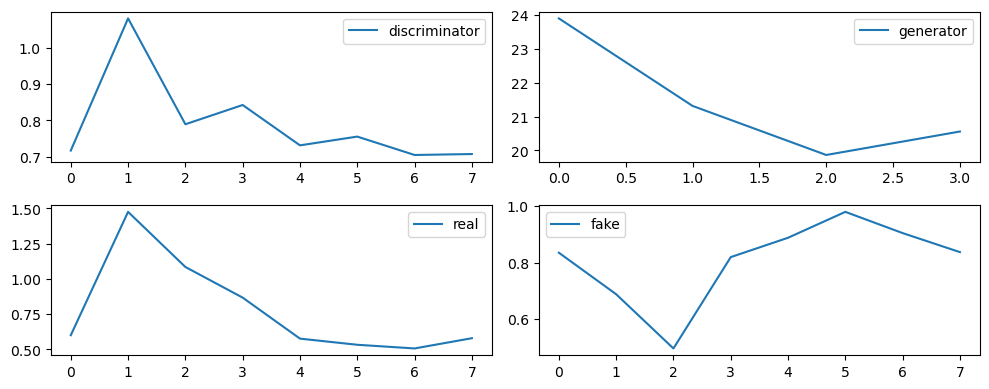

ValueError: Third dimension must be 3 or 4

In [22]:
# Train the models for 50 epochs
trainer.train(train_dl, epochs=1) 	

In [ ]:
trainer.plot_ssim_and_colourfulness()

In [ ]:
trainer._plot_losses() 	# Plot the generator and discriminator losses per epoch

In [ ]:
trainer.G	# Set the generator to evaluation mode